In [3]:
import math
import numpy as np

import pandas as pd
import scipy.io as io
import os 
import csv

from tqdm import tqdm 

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from torch.utils.tensorboard import SummaryWriter

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from FCAEClass import FCAE
from RespDataClass import RespData

c:\Users\weightwater\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 辅助函数
- 预测网络结果
- 制造白噪声
- 计算误差，MSE
- 绘制误差分布

In [4]:
def predict(test_loader, model, device):
    model.eval()
    preds = torch.Tensor([])
    for x in tqdm(test_loader):
        x = x.float().to(device)
        with torch.no_grad():
            pred = model(x)
            preds = torch.concat((preds, pred.detach().to('cpu')))
    # prds = torch.cat(preds, dim=0).numpy()
    return preds


In [5]:
from utils import getMSE, draw_hitogram

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mouseID = 1

Respdata = io.loadmat('./Main experiments/Mouse 1/RespData.mat')
Respdata = Respdata['RespData'][0][0][0][0][0][0]
repeatNum, frameNum, cellNum, sessionNum = Respdata.shape

stride = 6


#### 加载数据

In [7]:
PDG_Data = [np.load(f'./myData/Day{i*7}_PDG/PDG_mouse{mouseID}_FCAE.npy') for i in range(sessionNum)]
MOV_Data = np.load(f'./myData/Day0_MOV/MOV_mouse1_FCAE.npy')
# whiteNoisy_Data = np.random.normal(0, 1, (10000, stride*cellNum))

In [9]:
PDG_Dataset = [RespData(d) for d in PDG_Data]
MOV_Dataset = RespData(MOV_Data)
# whiteNoisy_Dataset = RespData(whiteNoisy_Data)

PDG_Dataloader = [DataLoader(PDGset, batch_size=16) for PDGset in PDG_Dataset]
MOV_Dataloader = DataLoader(MOV_Dataset, batch_size=16)
# whiteNoisy_Dataloader = DataLoader(whiteNoisy_Dataset, batch_size=16)

In [8]:
model = FCAE(cellNum*stride)
model.load_state_dict(torch.load('./FCAE/last_08261732_mouse1_day0.ckpt'))
model.to(device)

FCAE(
  (encoder): Sequential(
    (0): Linear(in_features=2226, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=2226, bias=True)
  )
)

In [10]:
PDG_Predictions = [predict(loader, model, device) for loader in PDG_Dataloader]
MOV_Predictions = predict(MOV_Dataloader, model, device)
# whiteNoisy_Predictions = predict(whiteNoisy_Data, model, device)

100%|██████████| 563/563 [00:06<00:00, 86.32it/s] 


In [11]:
PDG_MSE = [getMSE(d, pred.numpy()) for d, pred in zip(PDG_Data, PDG_Predictions)]
MOV_MSE = getMSE(MOV_Data, MOV_Predictions.numpy())
# whiteNoisy_MSE = getMSE(whiteNoisy_Data.numpy(), whiteNoisy_Predictions.numpy())

In [12]:
PDG_df = [pd.DataFrame(mse, columns=[f'MSE Day {i*7}']) for i, mse in enumerate(PDG_MSE)]
MOV_df = pd.DataFrame(MOV_MSE, columns=[f'MSE'])

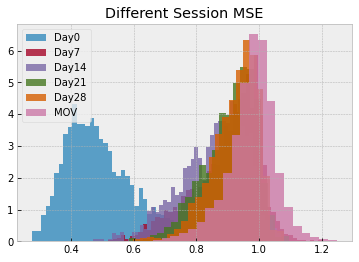

In [13]:
# Fixing random state for reproducibility
np.random.seed(19680801)

plt.style.use('bmh')
fig, ax = plt.subplots()
# print(PDG_df)
ax.hist(PDG_df[0][PDG_df[0]['MSE Day 0'] < 1.25], histtype="stepfilled", bins=50, alpha=0.8, density=True, label='Day0')
ax.hist(PDG_df[1][PDG_df[1]['MSE Day 7'] < 1.25], histtype="stepfilled", bins=50, alpha=0.8, density=True, label='Day7')
ax.hist(PDG_df[2][PDG_df[2]['MSE Day 14'] < 1.25], histtype="stepfilled", bins=50, alpha=0.8, density=True, label='Day14')
ax.hist(PDG_df[3][PDG_df[3]['MSE Day 21'] < 1.25], histtype="stepfilled", bins=25, alpha=0.8, density=True, label='Day21')
ax.hist(PDG_df[4][PDG_df[4]['MSE Day 28'] < 1.25], histtype="stepfilled", bins=25, alpha=0.8, density=True, label='Day28')
ax.hist(MOV_df[MOV_df['MSE'] < 1.25], histtype="stepfilled", bins=25, alpha=0.8, density=True, label='MOV')
# ax.hist(whiteNoise_df[whiteNoise_df['MSE'] < 1.25], histtype="stepfilled", bins=25, alpha=0.8, density=True, label='WN')
ax.set_title("Different Session MSE")

ax.legend(loc='upper left')

plt.show()
# plt.savefig('./LSTMAE_DAY.jpg', dpi=400)

#### 统计误差MSE较小的特征，或是小于AutoEncoder阈值的特征

- 顺序遍历寻找低MSE的Cellid
- 顺序遍历所有连续帧寻找MSE低的段落

In [13]:
timeMSETable = [{i: 0 for i in range(14)} for j in range(sessionNum)]
timeNUMTable = [{i: 0 for i in range(14)} for j in range(sessionNum)]

cellNumTable = [{i: 0 for i in range(cellNum)} for j in range(sessionNum)]
cellMSETable = [{i: 0 for i in range(cellNum)} for j in range(sessionNum)]

In [14]:
for i, MSE in enumerate(PDG_MSE):
    for j, mse in enumerate(MSE):
        if j % 20 < 14:
            timeMSETable[i][j%20] += mse
            timeNUMTable[i][j%20] += 1
    for j in range(14):
        timeMSETable[i][j] /= timeNUMTable[i][j]

In [15]:
for table in timeMSETable:
    print(table)

{0: 0.486528396278239, 1: 0.48085265150880846, 2: 0.4756913032294141, 3: 0.4672226511873598, 4: 0.46297778706277226, 5: 0.457220730100137, 6: 0.4588268690563937, 7: 0.45869007577206683, 8: 0.46272314559118466, 9: 0.47349069514304903, 10: 0.47008881815838555, 11: 0.4745266506311741, 12: 0.4759057493178847, 13: 0.4855929244822132}
{0: 0.855122885776617, 1: 0.8604512217440027, 2: 0.8655575309877187, 3: 0.8714577722889462, 4: 0.8756000938145901, 5: 0.8792854808742555, 6: 0.8847901855880805, 7: 0.8895475383215169, 8: 0.8956155994731239, 9: 0.8993232579145518, 10: 0.90505867087208, 11: 0.910248822262857, 12: 0.9180420557980079, 13: 0.9274851196591188}
{0: 0.7905949458708116, 1: 0.799535660006648, 2: 0.8112442366381373, 3: 0.8184257878637226, 4: 0.8252177211225468, 5: 0.8329309146129743, 6: 0.844655280829461, 7: 0.8542083062244221, 8: 0.8641443740433351, 9: 0.8739896573198399, 10: 0.878629277706087, 11: 0.8845635966814106, 12: 0.8886587498917856, 13: 0.8946863911675935}
{0: 0.848671671744329,

In [16]:
print(timeMSETable[0].keys(), timeMSETable[0].values())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]) dict_values([0.486528396278239, 0.48085265150880846, 0.4756913032294141, 0.4672226511873598, 0.46297778706277226, 0.457220730100137, 0.4588268690563937, 0.45869007577206683, 0.46272314559118466, 0.47349069514304903, 0.47008881815838555, 0.4745266506311741, 0.4759057493178847, 0.4855929244822132])


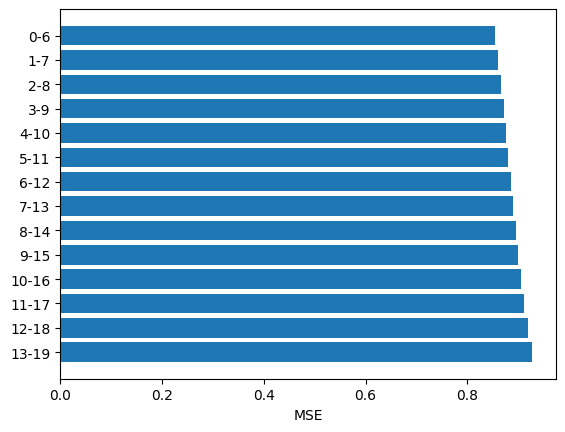

In [17]:
gap = [f'{i}-{i+6}' for i in range(14)]

np.random.seed(19680801)
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(list(timeMSETable[1].keys()), list(timeMSETable[1].values()))
ax.set_yticks(list(timeMSETable[1].keys()), gap)
ax.invert_yaxis()
ax.set_xlabel('MSE')

plt.show()
